# 이미지 분류 test1

In [ ]:
from PIL import Image
%matplotlib inline
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

In [ ]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [ ]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                            ])

dataset = torchvision.datasets.ImageFolder(root = './drive/MyDrive/Colab Notebooks/image', transform = trans)
print(len(dataset))
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)

1064
798
266
Dataset ImageFolder
    Number of datapoints: 1064
    Root location: ./drive/MyDrive/Colab Notebooks/image
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [ ]:
trainloader = DataLoader(datasets['train'].dataset,
                         batch_size = 4,
                         shuffle = True,
                         num_workers = 4)

testloader = DataLoader(datasets['val'].dataset,
                         batch_size = 4,
                         shuffle = True,
                         num_workers = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for X, y in testloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Shape of X [N, C, H, W]:  torch.Size([4, 3, 32, 32])
Shape of y:  torch.Size([4]) torch.int64


In [ ]:
# 학습용 디바이스 정보 획득
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [ ]:
# # 모델 정의
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(28*28, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10),
#             nn.ReLU()
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits



In [ ]:
# Neural Network를 정의하기 위해서 Class를 구현해봅니다.
# nn.Module 기억하세요 !

## ( input_size - filter_size ) / stride + 1 ---> activation map의 size

import torch.nn as nn
import torch.nn.functional as F

# nn.Module을 상속받는다. (내가 만들고 싶은 CNN 구조를 만들 수 있음)
class NeuralNetwork(nn.Module): 

    # input -> conv1 -> relu -> conv2 -> relu -> pool -> fc
    # 32x32x6 -> 28x28x6 -> 24x24x16 -> 12x12x16
    def __init__(self): # 생성자 call, 예를들면 from sklearn.porcessing import LabelEncoder -> encoder = LabelEncoder() 이런거랑 비슷, 기본적으로 self가 무조건 들어감
        super().__init__()        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6,kernel_size=5)   # cnn 첫번째 convolutional 생성, 처음의 채널은3개, 필터는 6개(지정), kerner 크기 5*5
        self.relu = nn.ReLU()                                                 # 위의 과정에서 생긴 28*28*6 을 Relu로, ReLu는 똑같이 생겨서 굳이 다시 정의 안함(pool도 마찬가지)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # 두번째 conv정의 # 보통 쓰던 kerner-size를 씀
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                     # pooling 정의 # 크기 줄이기, 겹치지않게
        self.fc = nn.Linear(in_features=12*12*16, out_features=10)            # fc 정의 # 출력은 무조건 10

    # 위에 정의된 함수를 이제 순서대로 실행하게 만들자
    def forward(self,x): # x = input
        x = self.conv1(x) # 32x32x3 -> 28x28x6
        x = self.relu(x)
        x = self.conv2(x) # 28x28x6 -> 24x24x16
        x = self.relu(x)
        x = self.pool(x) # 24x24x16 -> 12x12x16
        x = torch.flatten(x,1) # 2차원 Matrix를 1차원 Vector로 만들어준다
        x = self.fc(x)
        return x
        # 한줄로 표현할수는 있다. 합성함수의 느낌만 보자 # return self.fc(torch.flatten(self.pool(self.relu(self.conv2(self.relu(self.conv1(x))))), 1))

In [ ]:
# 모델 학습을 위한 디바이스 설정
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2304, out_features=10, bias=True)
)


In [ ]:
# 모델 학습 솔류션 수렴을 위한 최적화 모델 정의
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
# 훈련 함수 정의
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# 테스트 함수 정의
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 1  # 학습을 원하는 만큼 수정요
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(testloader, model)
print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss: 2.302049  [    0/ 1064]
loss: 1.220769  [  400/ 1064]
loss: 0.220264  [  800/ 1064]
Test Error: 
 Accuracy: 81.6%, Avg loss: 0.137031 

Done!


In [ ]:
torch.device('cuda')

device(type='cuda')

In [ ]:
classes = [
    'acc',
    'bag',
    'car',
    'eletronic'
]

In [ ]:
pre = model(X)
_, test = torch.max(pre,1)

In [ ]:
test

tensor([3, 3, 3, 3])

In [ ]:
y

tensor([1, 3, 1, 3])

In [ ]:
# 모델 평가
model.eval()
for X, y in testloader:
      X, y = X.to(device), y.to(device)

with torch.no_grad():
    pred = model(X)  
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(labels)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([ 7,  6, 10,  7])


In [ ]:
def imshow(img):
  img = img /2 +0.5
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1,2,0)))

  print(np_img.shape)
  print((np.transpose(np_img, (1,2,0))).shape)

torch.Size([4, 3, 100, 100])
(3, 104, 410)
(104, 410, 3)
torch.Size([4, 3, 100, 100])
torch.Size([3, 104, 410])
electronic ceramic   nan electronic 


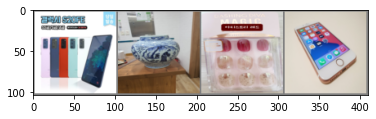

In [ ]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(4)))

In [ ]:
len(images)

4

# 이미지 분류 테스트2
- 강사님 코드 참고

In [ ]:
from PIL import Image
%matplotlib inline
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

In [ ]:
## 사진 train, test로 분리하는 함수
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [ ]:
trans = transforms.Compose([transforms.Resize((512,512)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                            ])

dataset = torchvision.datasets.ImageFolder(root = './drive/MyDrive/Colab Notebooks/image', transform = trans)
print(len(dataset))
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)

In [ ]:
## train, test 셋 dataloader 처리
trainloader = DataLoader(datasets['train'].dataset,
                         batch_size = 4,
                         shuffle = True,
                         num_workers = 4)

testloader = DataLoader(datasets['val'].dataset,
                         batch_size = 4,
                         shuffle = True,
                         num_workers = 4)

In [ ]:
## 라벨값 매칭을 위한 클래스 지정
classes = [
    'acc',
    'bag',
    'car',
    'eletronic',
    'jewelry',
    'm_wear',
    'shoes',
    'sports',
    'w_wear'
]

In [ ]:
for X, y in testloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

In [ ]:
# 학습용 디바이스 정보 획득
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

In [ ]:
# Neural Network를 정의하기 위해서 Class를 구현해봅니다.

## ( input_size - filter_size ) / stride + 1 ---> activation map의 size

import torch.nn as nn
import torch.nn.functional as F

# nn.Module을 상속받는다. (내가 만들고 싶은 CNN 구조를 만들 수 있음)
class NeuralNetwork(nn.Module): 

    # input -> conv1 -> relu -> conv2 -> relu -> pool -> fc
    # 512x512x3 -> 254x254x10 -> 124x124x24 -> 62x62x24
    def __init__(self): 
        super().__init__()        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10,kernel_size=6,stride=2)   
        self.relu = nn.ReLU()                                                 
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=24, kernel_size=6,stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                     # pooling 정의 # 크기 줄이기, 겹치지않게
        self.fc = nn.Linear(in_features=62*62*24, out_features=10)            # fc 정의 # 출력은 무조건 10

    # 위에 정의된 함수를 이제 순서대로 실행하게 만들자
    def forward(self,x): # x = input
        x = self.conv1(x) # 512x512x3 -> 254x254x10
        x = self.relu(x)
        x = self.conv2(x) # 254x254x10 -> 124x124x24
        x = self.relu(x)
        x = self.pool(x) # 124x124x24 -> 62x62x24
        x = torch.flatten(x,1) # 2차원 Matrix를 1차원 Vector로 만들어준다
        x = self.fc(x)
        return x
        # 한줄로 표현할수는 있다. 합성함수의 느낌만 보자 # return self.fc(torch.flatten(self.pool(self.relu(self.conv2(self.relu(self.conv1(x))))), 1))

In [ ]:
# 모델 학습을 위한 디바이스 설정
model = NeuralNetwork().to(device)
print(model)

In [ ]:
# 모델 학습 솔류션 수렴을 위한 최적화 모델 정의
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
# 훈련 함수 정의
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# 테스트 함수 정의
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5  # 학습을 원하는 만큼 수정
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(testloader, model)
print("Done!")

## 모델을 사용해서 결과 출력
1. 가져온 사진을 불러오기 
2. tensor로 변환 
3. 모델에 대입 => 대입이 원하는 방식대로 작동이 잘 안되고 있음
4. 라벨출력 => 3번과 마찬가지

In [ ]:
# test셋으로 어떤식으로 작동하는지 확인
for X, y in testloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
_, test = torch.max(pred,1)

In [ ]:
# 실제값 예측값 비교
with torch.no_grad():
    pred = model(X)
    for i in range(len(pred)):
      predicted, actual = classes[test[i]], classes[y[i]]
      print('pred : ' ,predicted)
      print('actual : ',actual)

## 확인용 사진셋 불러오기

In [ ]:
trans = transforms.Compose([transforms.Resize((512,512)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                            ])

dataset = torchvision.datasets.ImageFolder(root = './drive/MyDrive/Colab Notebooks/test', transform = trans)
print(len(dataset))

In [ ]:
batch_size = 4
dataloader = DataLoader(dataset,
                         batch_size = 4,
                         shuffle = False,
                         num_workers = 4)

In [ ]:
# 학습용 디바이스 정보 획득
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

In [ ]:
# 확인해볼 데이터셋 이미지로 확인
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader)
images, labels = dataiter.next() 

imshow(torchvision.utils.make_grid(images))
print(" ".join("%s\t" % classes[j] for j in range(batch_size)))

In [ ]:
with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
        pred = model(X)
_, test = torch.max(pred,1)

for i in range(len(pred)):
  predicted = classes[test[i]]
  print('pred : ' ,predicted)

In [ ]:
test

# image 분류 테스트(유툽)
- torch 활용

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=10)
# plt.rc('font', family='NanumBarunGothic')
# matplotlib.font_manager._rebuild()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [ ]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/drive/MyDrive/Colab Notebooks/shopee'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 908
테스트 데이터셋 크기: 224
클래스: ['acc', 'bag', 'electronic']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 시각화

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


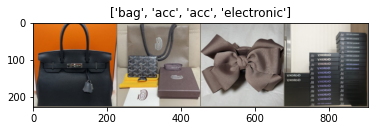

In [ ]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

* 학습할 CNN 딥러닝 모델 객체를 초기화합니다.

In [ ]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [25]:
num_epochs = 15 #50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#0 Loss: 0.8280 Acc: 69.7137% Time: 473.5052s
#1 Loss: 0.6541 Acc: 76.2115% Time: 941.7018s


KeyboardInterrupt: ignored

In [ ]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

In [ ]:
from PIL import Image


image = Image.open('./drive/MyDrive/Colab Notebooks/image/acc/75.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

* 웹 API 개방을 위해 <b>Ngrok</b> 서비스를 이용합니다.
* API 기능 제공을 위해 <b>Flask 프레임워크</b>를 사용합니다.

In [ ]:
# 필요한 라이브러리 설치하기
!pip install flask-ngrok

In [ ]:
import io
from flask_ngrok import run_with_ngrok
from flask import Flask, jsonify, request


# 이미지를 읽어 결과를 반환하는 함수
def get_prediction(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    image = transforms_test(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    return class_names[preds[0]]


app = Flask(__name__)


@app.route('/', methods=['POST'])
def predict():
    if request.method == 'POST':
        # 이미지 바이트 데이터 받아오기
        file = request.files['file']
        image_bytes = file.read()

        # 분류 결과 확인 및 클라이언트에게 결과 반환
        class_name = get_prediction(image_bytes=image_bytes)
        print("결과:", {'class_name': class_name})
        return jsonify({'class_name': class_name})

In [ ]:
run_with_ngrok(app)
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://fcaf-34-69-159-130.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
 * Running on http://fcaf-34-69-159-130.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
